# 앙상블 학습과 랜덤 포레스트

- 예측기 == 앙상블

- 대중의 지혜 : 복잡한 질문에 대한 무작위로 선택된 수천 명의 사람의 대답이 전문가의 답보다 낫다
- 앙상블 학습 ensemble learning : 일련의 예측기의 예측 성능이 가장 좋은 모델 하나의 예측 성능보다 좋다. 

- 앙상블 학습 알고리즘 == 앙상블 방법 ensemble method

앙상블 방법 예시) 
1. train dataset에서 무작위로 중복없는 서브셋을 만든다. 
2. 서브셋으로 일련의 결정 트리 분류기를 훈련한다.
3. 예측하려면 모든 개별 트리의 예측을 구한다.
4. 가장 많은 선택을 받은 클래스를 예측으로 삼는다.
- 결정 트리의 앙상블 == 랜덤 포레스트 

- 앙상블 방법 종류 : 배깅, 부스팅, 스태킹

다양한 분류기 만들기
1. 다른 훈련 알고리즘 사용하기
2. 같은 훈련 알고리즘을 사용하기 & 다른 데이터셋 사용하기(훈련 세트의 서브셋을 무작위로 구성)

## 1. 투표 기반 분류기

1) 매우 간단한 방법
- 다양한 예측기의 예측을 모아서 가장 많이 선택된 클래스로 예측한다.
- 다수결 투표로 정해지는 분류기 = 직접 투표 hard voting 분류기
- 각기 다른 알고리즘으로 학습하는게 좋음
- 원리 : 횟수를 거듭할수록 확률은 계속 달라지고 특정 예측값인 것의 확률이 계속 올라갈 수 있기 때문
- 조건 : 모든 분류기가 완전히 독립적, 오차에 상관관계가 없어야 함
- 이 방법으로 하기 힘든점 : 보통 같은 데이터로 훈련하고, 같은 종류의 오차를 만들기 쉽다


In [110]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 3개의 모델
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# 투표 기반 분류기
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) # 정확도

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


VotingClassifier 의 성능이 가장 좋은 것을 확인할 수 있다.

- 이처럼 predict_proba() 메서드를 가지고있어 클래스의 확률을 구할 수 있다면 앙상블 학습이 가능하다.
- 개별 분류기의 예측을 평균내고 확률이 가장 높은 클래스로 예측한다. = 간접 투표 soft voting
- `VotingClassifier(voting="soft")`
- 확률을 제공하지 않는 경우_ SVC와 같은 경우 `probaility=True` 로 설정하여 확률을 제공받음

## 2. 배깅과 페이스팅
dataset을 sampling하는 방식

- 배깅 bagging : training dataset에서 중복 허용한 sampling 방식
- 페이스팅 pasting : training dataset에서 중복 허용하지않은 sampling 방식
So, 배깅과 페이스팅에서 하나의 training dataset으로 분류기에 쓸 수 있다. 

여기서 sampling 하는 것을 부트스트랩이라고 한다.

- 부트스래핑 -> 각 예측키 서브셋 다양성 증가 -> (배깅 편향성 > 페이스팅 편향성) 
    + (다양성 추가 = 예측기 상관관계 감소 = 앙상블 분산 감소)

수집함수로 보통 {분류 : 통계적 최빈값}, {회귀 : 평균값} 를 지정한다.

개별 예측키는 편향과 분산값이 크지만, 수집함수를 통과하면 편향과 분산값이 감소한다. 

할 수 있다면 배깅과 페이스팅 교차검증 실행하여 더 나은 설정 선택

예측기는 모두 다른 CPU 코어 혹은 서버에 병렬로 학습이 가능하다.
예측도 병렬 수행이 가능하다.

### 2.1 사이킷런의 배깅과 페이스팅
사이킷런의 BaggingClassifier API 사용가능

예) Decision Tree 분류기 500개 앙상블을 훈련시켜보자. \
BaggingClassifier에 DecisionTreeClassifier 넣어 만들기 
1. training dataset 중복 허용, 무작위로 100개 샘플링
2. n_jobs 로 training, predict시 사용할 CPU 코어 갯수 지정 (-1은 모든 코어 사용)

In [111]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- BaggingClassifier로 만든 모델의 정확도

In [112]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


- Decision Tree로만 만든 모델의 정확도 \
배깅 방법으로 샘플링하여 앙상블 학습한 모델의 정확도가 더 높다.

In [113]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [114]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


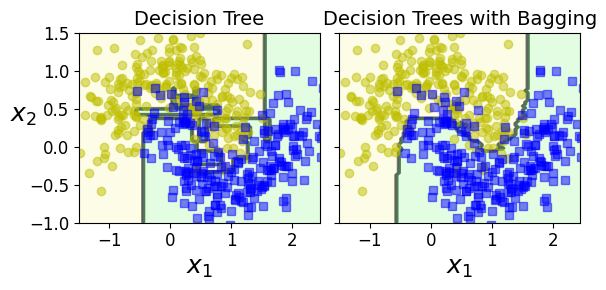

In [115]:
fig, axes = plt.subplots(ncols=2, figsize=(6,3), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

- 더 적은 편향과 더 적은 분산

### 2.2 oob평가
앙상블 평가하는 방법 \
배깅 샘플링 방법을 선택 -> 중복허용이 되므로 전체 데이터 중 선택되지 않은 데이터 발생 -> 선택되지 않은 샘플 비율 = oob (out-of-bag) 샘플

training한 앙상블 모델에 학습시 사용되지 않은 데이터셋을 사용한다는 점에서 oob 샘플을 사용해 예측값을 뽑아내 평가할 수 있겠다. \
BaggingClassifier에서 oob_score=True로 설정, oob_score_ 변수를 통해 확인가능.

BaggingClassifier에 DecisionTreeClassifier 넣어 만들기 

In [116]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

oob_decision_function_ 변수 에서 결정 함수(각 훈련 샘플의 클래스 확률 return)의 값 확인

In [117]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## 3. 랜덤 패치와 랜덤 서브스페이스

특성 샘플링하기 \
특성 샘플링 조절 매개변수 : max_features, bootstrap_features

랜덤 패치 방식 random patches method : training 특성 & 샘플 모두 샘플링   \
랜덤 서브스페이스 방식 random subspaces method : training 특성만 샘플링 (bootstrap=False, max_samples=1.0, bootstrap_features=True, max_features=(1.0보다 작게))

## 4. 랜덤 포레스트
Usually 배깅/페이스팅 방법을 적용한 Decision Tree ensemble

RandomForestClassifier
- max_samples로 훈련 세트 크기 지정
- BaggingClassifier의 매개변수 가지고 있음 (Decision Tree Classifier의 매개변수와 앙상블 자체를 제어한다)
- 전체가 아닌 무작위로 선택한 특성 후보 중 최적의 특성을 찾는다. 
- 무작위성이 주입돼서 트리가 더 다양해짐. 다양해진다=='분산' 감소 (bootstraping 참고, (다양성 추가 = 예측기 상관관계 감소 = 앙상블 분산 감소))

예) 500개 트리로 이루어진 랜덤 포레스트 분류기를 여러 CPU코어에서 훈련시키기 

1. RandomForestClassifier 사용 



In [118]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

2. Decision Tree에 최적화 (앞서서는 BaggingClassifier에 DecisionTreeClassifier 넣어 만듦) 

In [119]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

RandomForestClassifier 분류기와 BaggingClassifier - DecisionTreeClassifier 분류기 비교 \
결과값이 아주 같다.

In [120]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

### 4.1 엑스트라 트리

최적의 임곗값 searching - 가장 시간이 많이 소요되는 작업 -> 임곗값 대신 후보 특성 사용
random forest - 트리 만들기 (후보 특성을 사용해 무작위로 특성의 서브셋을 만들어 분할, 그 중 최상의 분할 선택)

익스트림 랜덤 트리 extremely randomized trees 앙상블 : 극단적 무작위 트리 랜덤 포레스트
편향 증가, 분산 감소

### 4.2 특성 중요도

랜덤 포레스트 이용한 특성의 상대적 중요도 측정 가능 - 중요한 특성을 빠르게 가려낼 수 있다.


scikit-learn 에서 제공하는 것 
- 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 계산, 가중치(연관된 훈련 샘플 수만큼 있다) 평균
- 특성마다 자동으로 점수 계산
- 중요도 전체 합이 1이 되도록 결과값 정규화
- feature_importances_ 변수에서 확인 가능


In [121]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [122]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

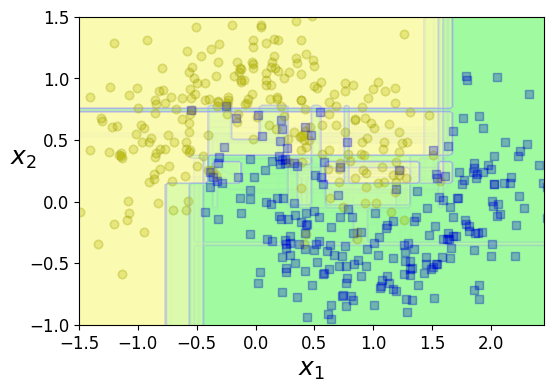

In [123]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [124]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

KeyboardInterrupt: 

## 5. 부스팅

- 앙상블 방법 중 하나
- 약한 학습기를 여러개 연결하여 강한 학습기를 만든다
- 앞의 모델을 보완해가면서 학습한다

- 부스팅 알고리즘 : 에이다부스트 AdaBoost, 그레이디언트 부스팅 gradient boosting 등 
    - 앙상블에 예측기를 순차적으로 추가
    - 이전 예측기 보완하며 새로운 예측기를 만드는 방법.
    
### 5.1 에이다부스트 AdaBoost
- dataset train 샘플별로 가중치를 조절하며 훈련하는 방법.
- 과소적합했던 훈련 샘플의 가중치를 더 높인다. (-> 학습이 어려운 data에 맞춰 모델링된다)
- 보완을 반복하며 성능이 좋아지는 과정이 경사 하강법 과정과 비슷하게 보일 수 있다.
- 경사 하강법 : 비용 함수를 최소화 / 에이다부스트 : 성능이 점차 좋아지도록 보완 반복
- 훈련 완료 후 배깅/페이스팅 방식으로 예측
- 에이다부스트 식 참조

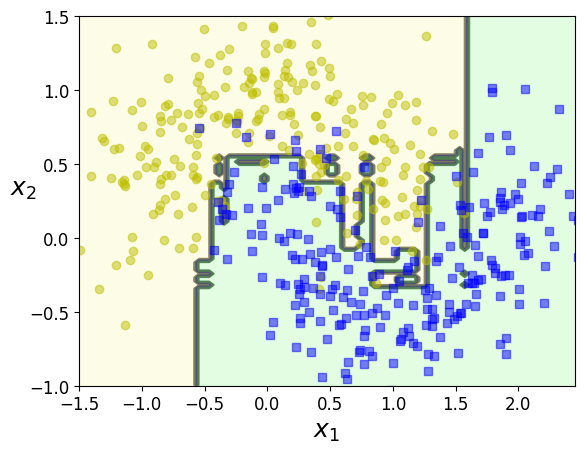

In [127]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=1.0, random_state=42)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


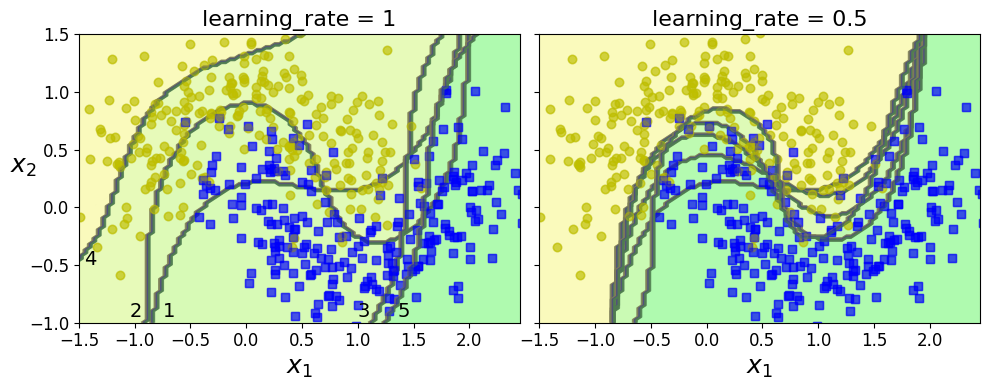

In [83]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

### 5.2 그레이디언트 부스팅 Gradient boosting
- 이전 예측기의 잔여 오차 residual error에 새로운 예측기를 학습시킨다
- 회귀 모델 : 그레이디언트 트리 부스팅 gradient tree boosting (gradient boosted regression tree(GBRT))

In [84]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

**Gradient boosting example) DecisionTreeRegressor 학습해보기 (잡읍이 섞인 2차 곡선 형태의 데이터셋)**
1. 첫 번째 모델

In [85]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1=DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

2. 첫 번째 모델을 이용한, Residual Error 값에 대해 학습한 두 번째 모델

In [87]:
y2=y-tree_reg1.predict(X)
tree_reg2=DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

3. 두 번째 모델을 이용한 세 번째 모델

In [88]:
y3=y2-tree_reg2.predict(X)
tree_reg3=DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

4. 완성된 모델에 대해서 새로운 샘플에 대한 예측을 보려면, 만들었던 모든 모델의 예측을 더한다.

In [89]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [90]:
print(tree_reg1.predict(X_new),tree_reg2.predict(X_new),tree_reg3.predict(X_new))
print(y_pred)

[0.52856846] [0.03991297] [0.18178637]
[0.75026781]


**Gradient Boosting을 scikit-learn을 이용해 GBRT 앙상블 간단히 구현하기**
- learning_rate : 각 트리의 기여 정도, 값에 따라 필요한 트리의 수가 달라진다. 낮게 설정하면 많은 트리가 필요하다(축소 규제 방법), So 최적의 트리 수 설정이 필요함

In [91]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [92]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


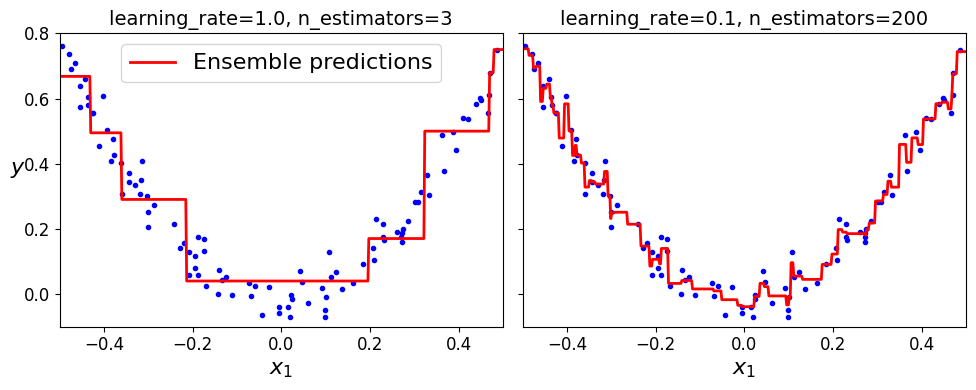

In [93]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

In [94]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [98]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

**최적의 트리수 구하기 staged_predict()** 

방법 : 120개 트리로 GBRT 앙상블 훈련 -> 각 훈련 단계에서 검증 오차 측정 -> 측정값을 이용한 최적의 트리 수 searching -> 최적의 트리수를 사용한 새로운 GBRT 앙상블 훈련

In [99]:
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [96]:
min_error = np.min(errors)
min_error

0.002712853325235463

Saving figure early_stopping_gbrt_plot


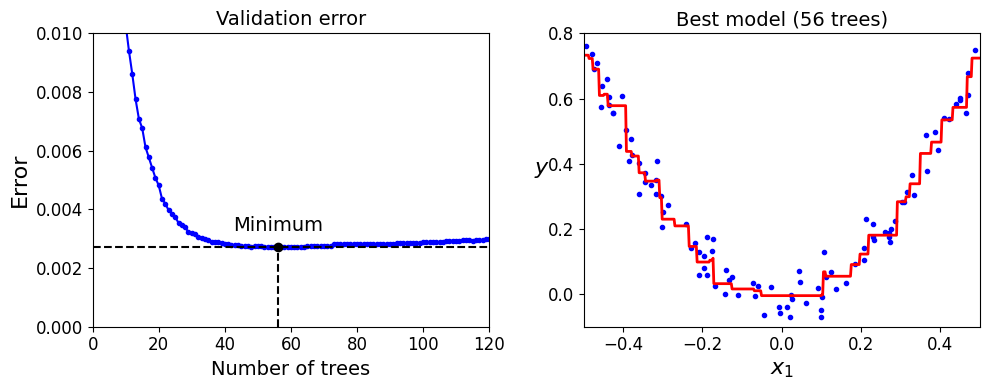

In [97]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

(왼)검증 오차, (오)최적의 모델 예측값

---

warm_start=True로 설정하여 기존 트리에 훈련을 추가할 수 있다. 

조기 종료 코드

In [100]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # MSE값
    if val_error < min_val_error: # MSE 값이 계속 줄어들면 error_going_up 값을 0으로 해준다.
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5: # 5번 연속 MSE값이 떨어지지않으면 멈춘다.
            break  # early stopping

print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

61
Minimum validation MSE: 0.002712853325235463


**GradientBoostingRegressor를 이용한 확률적 그레이디언트 부스팅 Stochastic gradient boosting 방법**
모델 정의시 GradientBoostingRegressor에 매개변수 **subsample=0.25(원하는 비율)** 을 추가한다.

**XGBoost (eXtreme Gradient Boosting)**
- 최적의 Gradient boosting 구현
- 매우 빠른 속도, 확장성, 이식성

In [106]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    !pip install xgboost
    xgboost = None

1. XGBoost 첫 번째 Model

In [107]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.004000408205406276


2. 첫 번째 모델에 fit()을 적용하여 추가적으로 앙상블 학습 

early_stopping_rounds 매개변수로 자동 조기 종료 

MSE 값이 계속 줄어드는 것이 목표

In [108]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


/Users/gahyunson/opt/anaconda3/envs/mywork/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


## 6. 스태킹 stacking

- 앙상블 모델
- 예측기를 취합하는 블렌더를 만드는 모델

**Hold-out 홀드 아웃 세트**

하나의 블렌더를 학습시키는 방법
1. dataset을 2개의 서브셋으로 나눈다
2. 1번째 서브셋은 1번째 레이어의 예측을 훈련시킨다
3. 1번째 레이어 예측기로 2번째 서브셋에 대한 예측값을 만든다
4. 레이어는 3개가 존재한다
5. 각 레이어가 만들어낸 3개의 예측값을 입력 특성으로 사용하는 새로운 dataset을 만들 수 있다
(dataset 차원은 3차원이 된다)
6. 새로운 dataset으로 블렌더를 training 한다
7. 예측값들로 타깃값을 만들어내도록 trainin하게 된다

여러개의 블렌더를 학습시키는 방법
1. 선형 회귀, 랜덤 포레스트 회귀... 다양한 종류 여러개의 블렌더 training 가능
2. 블렌더의 레이어가 생성됨
3. dataset 3개 서브셋으로 나누기
4. 1번째 서브셋은 1번째 레이어 훈련, 2번째 서브셋은 2번째 레이어 훈련, 3번째 서브셋은 3번째 레이어 훈련
5. 각 레이어를 차례로 실행해서 새로운 dataset에 대한 training과 예측값 생성 (타깃값에 맞도록)


---


